### Evaluate final U-Net models on CESM and FOCI sst data

In [31]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
    prepare_multivariate_data, 
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
    el_nino_southern_oscillation_34,
    atlantic_multidecadal_oscillation,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

In [13]:
## Specify parameters:

# Source: 'CESM', 'FOCI' or 'realworld'
source = 'FOCI'
feature = 'sea-surface-temperature'
feature_short = 'sst'
missing_values = [0.999,0.99,0.95]

# Further parameters for pre-processing inputs and targets:
train_val_split = 0.8
scale_to = 'zero_one'


## Set paths to final models and set shortnames for final models:

paths_to_final_models=[
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_sst_'+source+'_optimal_discrete_lead_0_final',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_sst_'+source+'_optimal_discrete_lead_1_final',
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_sst_'+source+'_optimal_discrete_lead_3_final',
]


model_shortnames=[
    'lead 0',
    'lead 1',
    'lead 3',
]

In [17]:
# Load test loss per sample for first model, to infer number of test samples, 
# lat and lon, and number of missing value rates. 
# Note: Infer number of test samples from last experiment with max. lead time.
n_test=np.load(Path(paths_to_final_models[-1]) / 'test_loss_per_sample_all.npy').shape[-1]
lat=np.load(Path(paths_to_final_models[0]) / 'test_loss_map_all.npy').shape[1]
lon=np.load(Path(paths_to_final_models[0]) / 'test_loss_map_all.npy').shape[2]
n_missing=np.load(Path(paths_to_final_models[0]) / 'test_loss_per_sample_all.npy').shape[0]

# # Initialize storage for parameters:
# feature_all = []
# feature_short_all = []
# source_all = []
# mask_type_all = []
# missing_type_all = []
# augmentation_factor_all = []
# missing_values_all = []

# Initialize storage for reloaded results, for all models and missing rates.
test_loss_per_sample_all = np.zeros((len(paths_to_final_models),n_missing,n_test))
test_loss_map_all = np.zeros((len(paths_to_final_models),n_missing,lat,lon))
ENSO_test_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_test))
ENSO_test_target_all = np.zeros((len(paths_to_final_models),n_missing,n_test))
AMO_test_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_test))
AMO_test_target_all = np.zeros((len(paths_to_final_models),n_missing,n_test))

# Loop over final models:
for i in range(len(paths_to_final_models)):
    
    # Get path to final model:
    path_to_final_model = paths_to_final_models[i]
    
    # Reload parameters for this experiment:
    with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
        parameters=load(f)

#     # Store parameters:    
#     feature_all.append(parameters['feature'])
#     feature_short_all.append(parameters['feature_short'])
#     source_all.append(parameters['source'])
#     mask_type_all.append(parameters['mask_type'])
#     missing_type_all.append(parameters['missing_type'])
#     augmentation_factor_all.append(parameters['augmentation_factor'])
#     missing_values_all.append(parameters['missing_values'])
    
    ## Reload results.   
    ## Different experiments have different lead time and hence, different number of test samples.
    ## Take number of test samples from last experiment with max. lead time and hence, minimum number of test samples.
    test_loss_per_sample_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'test_loss_per_sample_all.npy')[:,:n_test]
    test_loss_map_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'test_loss_map_all.npy')
    ENSO_test_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'ENSO_test_pred_all.npy')[:,:n_test]
    ENSO_test_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'ENSO_test_target_all.npy')[:,:n_test]
    AMO_test_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'AMO_test_pred_all.npy')[:,:n_test]
    AMO_test_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'AMO_test_target_all.npy')[:,:n_test]
    


### Indices (ENSO, AMO) on reconstructed vs. complete fields

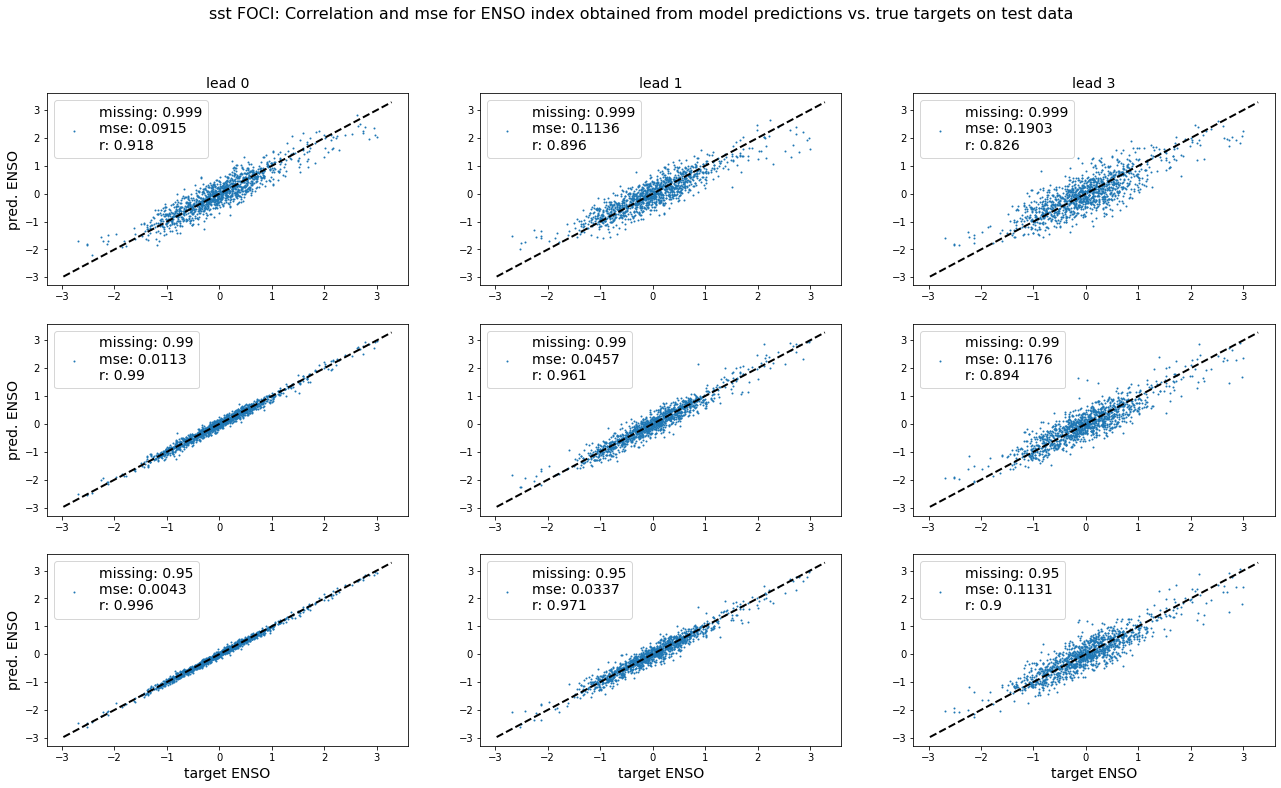

In [18]:
## sst FOCI

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_test

# Initialize plot for ENSO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(ENSO_test_target_all[model_number,r,:n_samples], ENSO_test_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values[r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((ENSO_test_target_all[model_number,r,:n_samples]-ENSO_test_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([ENSO_test_target_all[model_number,r,:n_samples],ENSO_test_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target ENSO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. ENSO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('sst FOCI: Correlation and mse for ENSO index obtained from model predictions vs. true targets on test data', fontsize=16)
plt.show()

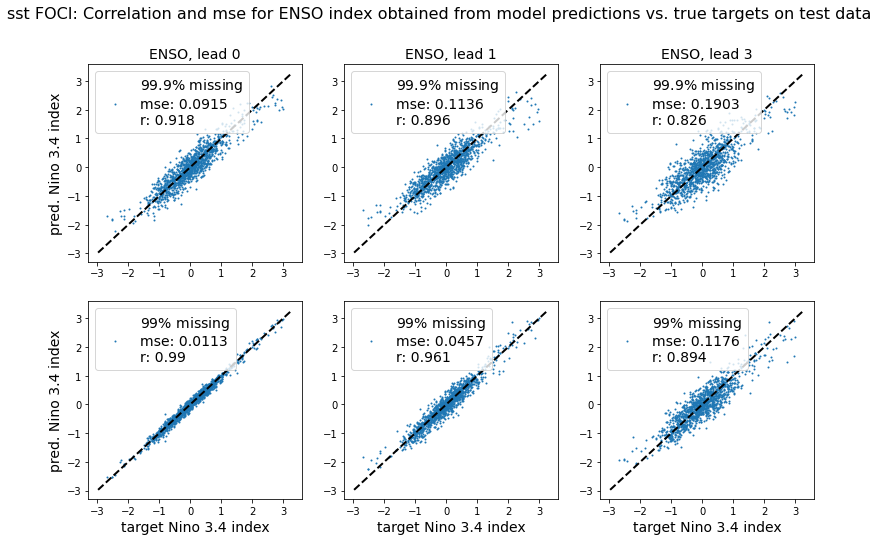

In [147]:
## sst FOCI

# Set missing rates for figure titles:
missing_rates = [99.9, 99, 95]

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 2

# Set number of samples to include:
n_samples = n_test

# Initialize plot for ENSO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(13,8))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(ENSO_test_target_all[model_number,r,:n_samples], ENSO_test_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     str(missing_rates[r])+'$\%$ missing'+'\nmse: '+
                                     str(np.round(np.mean(np.mean((ENSO_test_target_all[model_number,r,:n_samples]-ENSO_test_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([ENSO_test_target_all[model_number,r,:n_samples],ENSO_test_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title('ENSO, '+model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target Nino 3.4 index', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. Nino 3.4 index', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('sst FOCI: Correlation and mse for ENSO index obtained from model predictions vs. true targets on test data', fontsize=16)
plt.show()

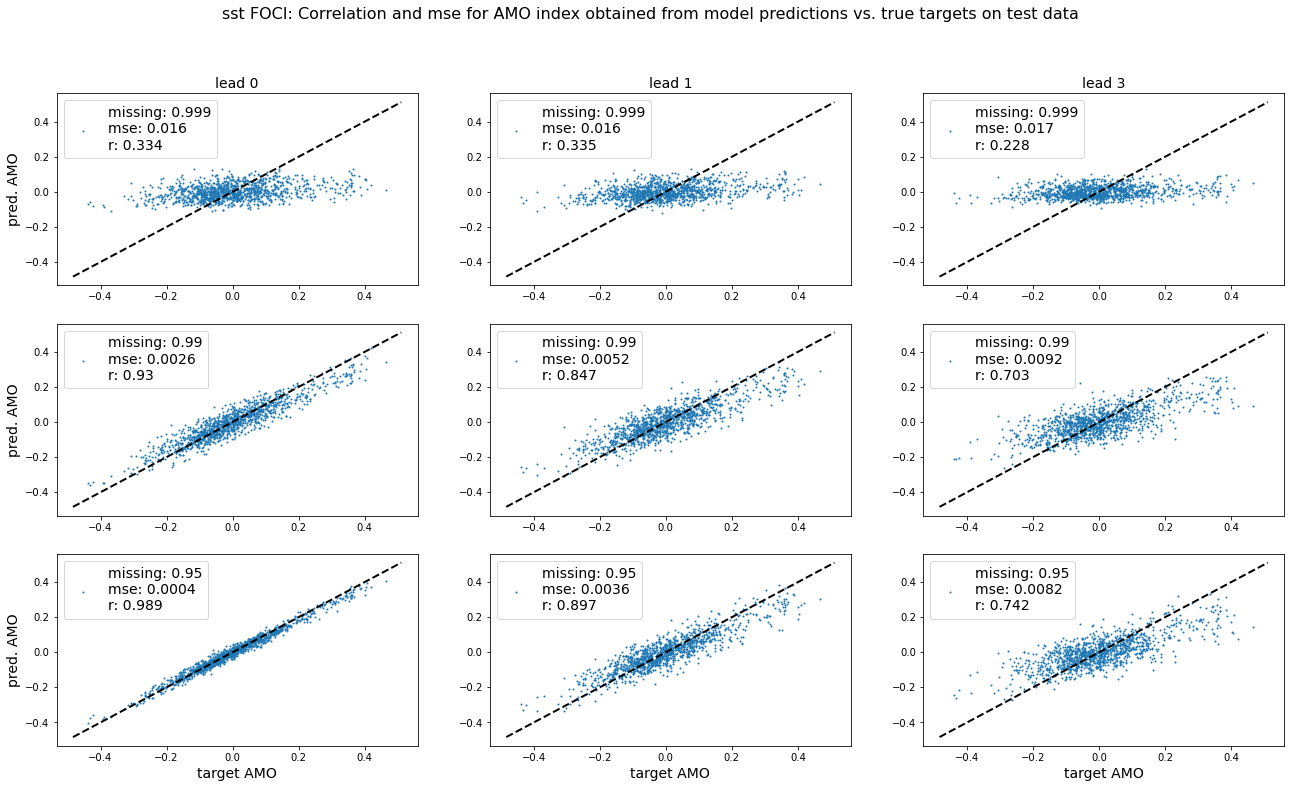

In [19]:
## sst FOCI

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_test

# Initialize plot for AMO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(AMO_test_target_all[model_number,r,:n_samples], AMO_test_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values[r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((AMO_test_target_all[model_number,r,:n_samples]-AMO_test_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([AMO_test_target_all[model_number,r,:n_samples],AMO_test_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target AMO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. AMO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('sst FOCI: Correlation and mse for AMO index obtained from model predictions vs. true targets on test data', fontsize=16)
plt.show()

### Find sample that illustrates the reconstruction from ultra sparse inputs for various lead times and missing rates

#### 99.9% missing

In [27]:
# Select model and missing rate:
model_n = 0
missing_n = 0

# Get current path to final model:
path_to_final_model = paths_to_final_models[model_n]

# Get current rate of missing values:
missing = missing_values[missing_n]

print('Model:', path_to_final_model)
print('Missing:', missing)


Model: GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_sst_FOCI_optimal_discrete_lead_0_final
Missing: 0.999


In [28]:
# Reload parameters for this experiment:
with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
    parameters=load(f)

data_source_name = parameters['data_source_name']
input_features = parameters['inpute_features']
target_feature = parameters['target_feature']
feature_short = parameters['feature_short']
load_samples_from = parameters['load_sample_from']
load_samples_to = parameters['load_samples_to']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
missing_values = parameters['missing_values']
seed = parameters['seed']
train_val_split = parameters['train_val_split']
val_test_split = parameters['val_test_split']
scale_to = parameters['scale_to']
shift = parameters['shift']

# Not stored in parameters file, but needed to reload optimal masks:
input_features_short=[
    'slp', 
    'sst', 
    'z500', 
    'sat', 
    'sss', 
    'prec'
]


In [33]:
## Restore input and target data:

# Path to full data:
path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

# Create paths to optimal masks.    
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:

    # Initialize storage:
    path_to_optimal_masks=[]

    # Loop over input features:
    for f in range(len(input_features_short)):

        # Create path for current feature:
        temp_path=(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_'
            +input_features_short[f]+'_'+data_source_name
            +'_variable_range_0_100_factor_3_final/relevance_1/'
            +'optimal_sampling_mask_'+str(int(missing*1000))+'.npy'
    )
        # Append path for current feature:
        path_to_optimal_masks.append(temp_path)

else:

    # Initialize storage:
    path_to_optimal_masks=[]

    # Loop over input features:
    for f in range(len(input_features_short)):

        # Create path for current feature:
        temp_path=(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_'
            +input_features_short[f]+'_'+data_source_name
            +'_variable_range_0_100_factor_3_final/relevance_1/'
            +'optimal_sampling_mask_'+str(int(missing*100))+'.npy'
    )
        # Append path for current feature:
        path_to_optimal_masks.append(temp_path)        


# Prepare data:
(
    _,
    _,
    test_input,
    _,
    _,
    test_target,
    train_min,
    train_max,
    train_mean,
    train_std,
) = prepare_multivariate_data(
        data_path=path_to_data, 
        data_source_name=data_source_name,
        input_features=input_features, 
        target_feature=target_feature,
        load_samples_from=load_samples_from, 
        load_samples_to=load_samples_to,
        mask_type=mask_type, 
        missing_type=missing_type, 
        missing_min=missing, 
        missing_max=missing, 
        seed=seed, 
        path_to_optimal_masks=path_to_optimal_masks,
        train_val_split=train_val_split,
        val_test_split=val_test_split,
        scale_to=scale_to,
        shift=shift,
)    

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
2023-04-05 09:50:37.131119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-04-05 09:50:37.131143: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-05 09:50:37.131159: I ten

In [36]:
# Set zero values in targets to NaN, to highlight land masses and correct contrast in SST anomalies:
test_target_nan = np.copy(test_target)
test_target_nan[test_target_nan==0] = float('nan')

In [51]:
# # ## Plot some test targets (=complete samples):

# # # Specify number of samples to consider:
# n_samples = 30

# # Loop over samples:
# for n in range(n_samples):
    
#     ## Plot target:
#     fig, ax = plt.subplots(figsize=(8, 3))
#     im = plt.imshow(test_target_nan[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
#     cbar = plt.colorbar(im)
#     cbar.set_label("scaled SST anomaly", fontsize=14)
#     plt.title('target = test input '+str(n), fontsize=14)
#     plt.xlabel('Longitude [°E]', fontsize=14)
#     plt.ylabel('Latitude [°N]', fontsize=14)
#     plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
#     plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
#     plt.show()

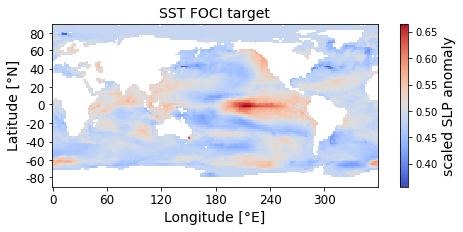

In [89]:
## Plot single target:

# Pick sample number:
sample = 23

# Plot:
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(test_target_nan[sample], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("scaled SLP anomaly", fontsize=14)
plt.title('SST FOCI target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [60]:
# Set lead times, according to models:
lead_times = [0, 1, 3]

# Initialize storage for model predictions on single sample with different lead times.
sample_pred_all = np.zeros((len(lead_times),lat,lon))

## Loop over models with different lead times:
for m in range(len(paths_to_final_models)):
    
    # Get current path to final model:
    path_to_final_model = paths_to_final_models[m]
    
    # Get corresponding lead time:
    lead = lead_times[m]
    
    # Reload model: Rel. amount of missing values = 0.999 requires special treatment.
    if missing==0.999:
        model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'model')
    else:
        model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'model')
        
    # Get model prediction: For selected target, need corresponding input, according to current lead time as shift:
    sample_pred_all[m] = model.predict(test_input[sample-lead:sample-lead+1])[0,:,:,0]

In [63]:
# Restore former NaN values in predictions, to highlight land masses:
sample_pred_all_nan = np.copy(sample_pred_all)
sample_pred_all_nan[test_target[:len(lead_times)]==0] = float('nan')

0.99  missing

log(mse):  -3.64 



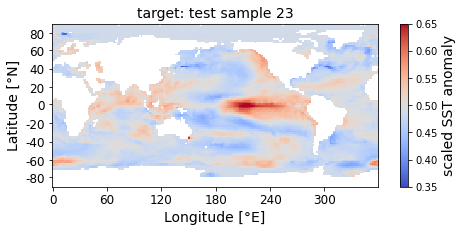

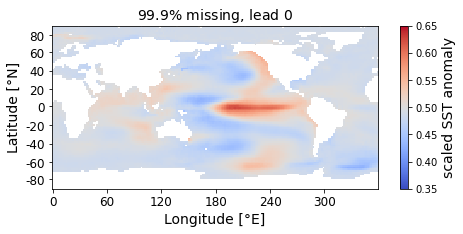

log(mse):  -3.52 



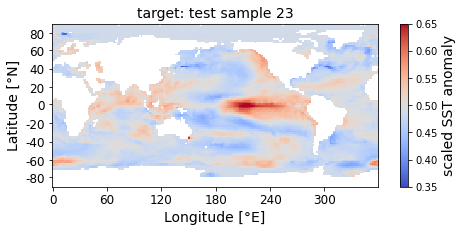

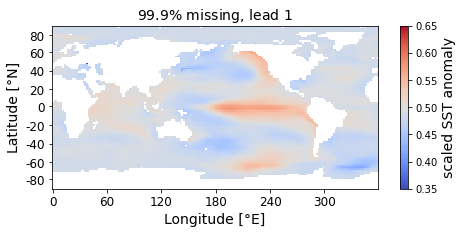

log(mse):  -3.57 



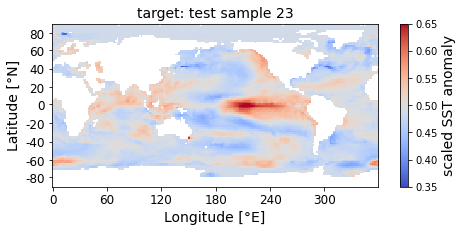

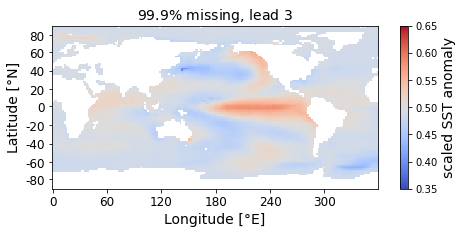

In [87]:
# Plot for specific rate of missing values all reconstructions from final models with different lead times plus target.

# Print current rate of missing values:
print(missing,' missing\n')

# Loop over models:
for m in range(len(model_shortnames)):
    
    # Print loss:
    print('log(mse): ',np.round(np.log10(np.mean((sample_pred_all[m]-test_target[sample])**2)),2),'\n')

    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(test_target_nan[sample], cmap="coolwarm", interpolation='nearest', vmin=0.35, vmax=0.65)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title('target: test sample '+str(sample), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

    # Plot model reconstructions for current final model with respective lead time:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(sample_pred_all_nan[m], cmap="coolwarm", interpolation='nearest', vmin=0.35, vmax=0.65)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title(r'$99.9\%$'+' missing, '+model_shortnames[m], fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

#### 99% missing

In [71]:
# Select model and missing rate:
model_n = 0
missing_n = 1

# Get current path to final model:
path_to_final_model = paths_to_final_models[model_n]

# Get current rate of missing values:
missing = missing_values[missing_n]

print('Model:', path_to_final_model)
print('Missing:', missing)


Model: GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_sst_FOCI_optimal_discrete_lead_0_final
Missing: 0.99


In [72]:
# Reload parameters for this experiment:
with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
    parameters=load(f)

data_source_name = parameters['data_source_name']
input_features = parameters['inpute_features']
target_feature = parameters['target_feature']
feature_short = parameters['feature_short']
load_samples_from = parameters['load_sample_from']
load_samples_to = parameters['load_samples_to']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
missing_values = parameters['missing_values']
seed = parameters['seed']
train_val_split = parameters['train_val_split']
val_test_split = parameters['val_test_split']
scale_to = parameters['scale_to']
shift = parameters['shift']

# Not stored in parameters file, but needed to reload optimal masks:
input_features_short=[
    'slp', 
    'sst', 
    'z500', 
    'sat', 
    'sss', 
    'prec'
]

In [73]:
## Restore input and target data:

# Path to full data:
path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

# Create paths to optimal masks.    
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:

    # Initialize storage:
    path_to_optimal_masks=[]

    # Loop over input features:
    for f in range(len(input_features_short)):

        # Create path for current feature:
        temp_path=(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_'
            +input_features_short[f]+'_'+data_source_name
            +'_variable_range_0_100_factor_3_final/relevance_1/'
            +'optimal_sampling_mask_'+str(int(missing*1000))+'.npy'
    )
        # Append path for current feature:
        path_to_optimal_masks.append(temp_path)

else:

    # Initialize storage:
    path_to_optimal_masks=[]

    # Loop over input features:
    for f in range(len(input_features_short)):

        # Create path for current feature:
        temp_path=(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_'
            +input_features_short[f]+'_'+data_source_name
            +'_variable_range_0_100_factor_3_final/relevance_1/'
            +'optimal_sampling_mask_'+str(int(missing*100))+'.npy'
    )
        # Append path for current feature:
        path_to_optimal_masks.append(temp_path)        


# Prepare data:
(
    _,
    _,
    test_input,
    _,
    _,
    test_target,
    train_min,
    train_max,
    train_mean,
    train_std,
) = prepare_multivariate_data(
        data_path=path_to_data, 
        data_source_name=data_source_name,
        input_features=input_features, 
        target_feature=target_feature,
        load_samples_from=load_samples_from, 
        load_samples_to=load_samples_to,
        mask_type=mask_type, 
        missing_type=missing_type, 
        missing_min=missing, 
        missing_max=missing, 
        seed=seed, 
        path_to_optimal_masks=path_to_optimal_masks,
        train_val_split=train_val_split,
        val_test_split=val_test_split,
        scale_to=scale_to,
        shift=shift,
)    

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [74]:
# Set zero values in targets to NaN, to highlight land masses and correct contrast in SST anomalies:
test_target_nan = np.copy(test_target)
test_target_nan[test_target_nan==0] = float('nan')

In [75]:
# Set lead times, according to models:
lead_times = [0, 1, 3]

# Initialize storage for model predictions on single sample with different lead times.
sample_pred_all_99 = np.zeros((len(lead_times),lat,lon))

## Loop over models with different lead times:
for m in range(len(paths_to_final_models)):
    
    # Get current path to final model:
    path_to_final_model = paths_to_final_models[m]
    
    # Get corresponding lead time:
    lead = lead_times[m]
    
    # Reload model: Rel. amount of missing values = 0.999 requires special treatment.
    if missing==0.999:
        model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*1000)}' / 'model')
    else:
        model = tf.keras.models.load_model(Path(path_to_final_model) / 'missing_' f'{int(missing*100)}' / 'model')
        
    # Get model prediction: For selected target, need corresponding input, according to current lead time as shift:
    sample_pred_all_99[m] = model.predict(test_input[sample-lead:sample-lead+1])[0,:,:,0]

In [76]:
# Restore former NaN values in predictions, to highlight land masses:
sample_pred_all_99_nan = np.copy(sample_pred_all_99)
sample_pred_all_99_nan[test_target[:len(lead_times)]==0] = float('nan')

0.99  missing

log(mse):  -3.93 



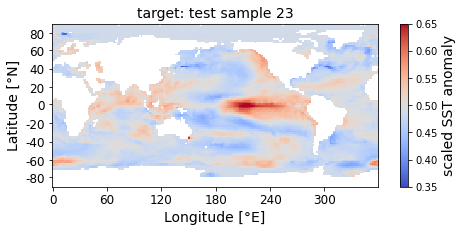

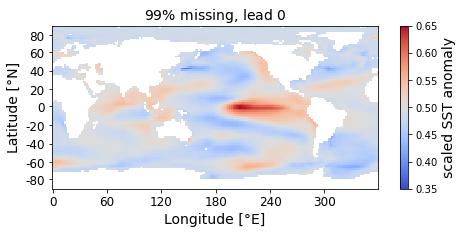

log(mse):  -3.77 



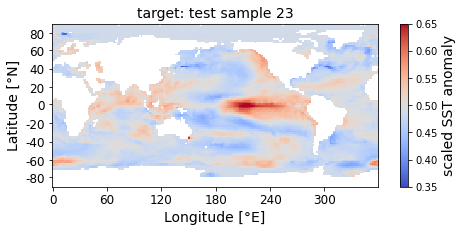

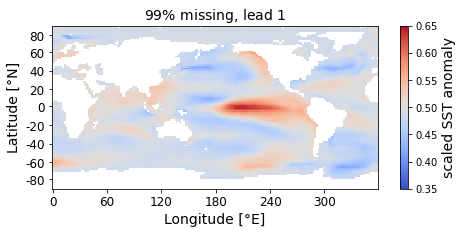

log(mse):  -3.57 



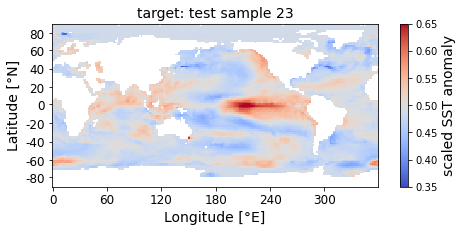

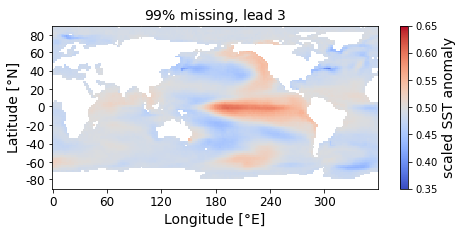

In [86]:
# Plot for specific rate of missing values all reconstructions from final models with different lead times plus target.

# Print current rate of missing values:
print(missing,' missing\n')

# Loop over models:
for m in range(len(model_shortnames)):
    
    # Print loss:
    print('log(mse): ',np.round(np.log10(np.mean((sample_pred_all_99[m]-test_target[sample])**2)),2),'\n')

    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(test_target_nan[sample], cmap="coolwarm", interpolation='nearest', vmin=0.35, vmax=0.65)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title('target: test sample '+str(sample), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

    # Plot model reconstructions for current final model with respective lead time:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(sample_pred_all_99_nan[m], cmap="coolwarm", interpolation='nearest', vmin=0.35, vmax=0.65)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title(r'$99\%$'+' missing, '+model_shortnames[m], fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

#### 95% missing

In [90]:
# Select model and missing rate:
model_n = 0
missing_n = 2

# Get current path to final model:
path_to_final_model = paths_to_final_models[model_n]

# Get current rate of missing values:
missing = missing_values[missing_n]

print('Model:', path_to_final_model)
print('Missing:', missing)


Model: GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_sst_FOCI_optimal_discrete_lead_0_final
Missing: 0.95


In [91]:
# Reload parameters for this experiment:
with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
    parameters=load(f)

data_source_name = parameters['data_source_name']
input_features = parameters['inpute_features']
target_feature = parameters['target_feature']
feature_short = parameters['feature_short']
load_samples_from = parameters['load_sample_from']
load_samples_to = parameters['load_samples_to']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
missing_values = parameters['missing_values']
seed = parameters['seed']
train_val_split = parameters['train_val_split']
val_test_split = parameters['val_test_split']
scale_to = parameters['scale_to']
shift = parameters['shift']

# Not stored in parameters file, but needed to reload optimal masks:
input_features_short=[
    'slp', 
    'sst', 
    'z500', 
    'sat', 
    'sss', 
    'prec'
]

In [92]:
## Restore input and target data:

# Path to full data:
path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

# Create paths to optimal masks.    
# Rel. amount of missing values = 0.999 requires special treatment:
if missing==0.999:

    # Initialize storage:
    path_to_optimal_masks=[]

    # Loop over input features:
    for f in range(len(input_features_short)):

        # Create path for current feature:
        temp_path=(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_'
            +input_features_short[f]+'_'+data_source_name
            +'_variable_range_0_100_factor_3_final/relevance_1/'
            +'optimal_sampling_mask_'+str(int(missing*1000))+'.npy'
    )
        # Append path for current feature:
        path_to_optimal_masks.append(temp_path)

else:

    # Initialize storage:
    path_to_optimal_masks=[]

    # Loop over input features:
    for f in range(len(input_features_short)):

        # Create path for current feature:
        temp_path=(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_'
            +input_features_short[f]+'_'+data_source_name
            +'_variable_range_0_100_factor_3_final/relevance_1/'
            +'optimal_sampling_mask_'+str(int(missing*100))+'.npy'
    )
        # Append path for current feature:
        path_to_optimal_masks.append(temp_path)        


# Prepare data:
(
    _,
    _,
    test_input,
    _,
    _,
    test_target,
    train_min,
    train_max,
    train_mean,
    train_std,
) = prepare_multivariate_data(
        data_path=path_to_data, 
        data_source_name=data_source_name,
        input_features=input_features, 
        target_feature=target_feature,
        load_samples_from=load_samples_from, 
        load_samples_to=load_samples_to,
        mask_type=mask_type, 
        missing_type=missing_type, 
        missing_min=missing, 
        missing_max=missing, 
        seed=seed, 
        path_to_optimal_masks=path_to_optimal_masks,
        train_val_split=train_val_split,
        val_test_split=val_test_split,
        scale_to=scale_to,
        shift=shift,
)    

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [102]:
# Define input features' short names with capital letters:
input_features_short_capital = ['SLP', 'SST', 'Z500', 'SAT', 'SSS', 'PREC']

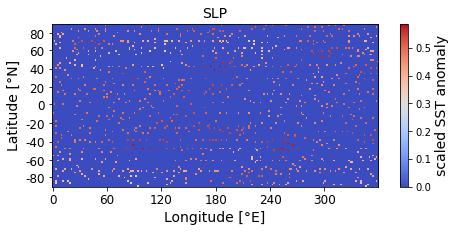

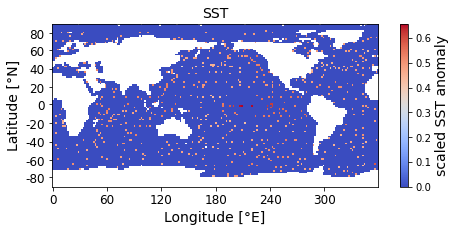

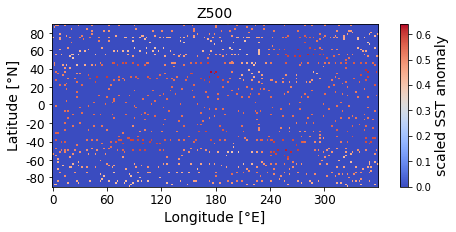

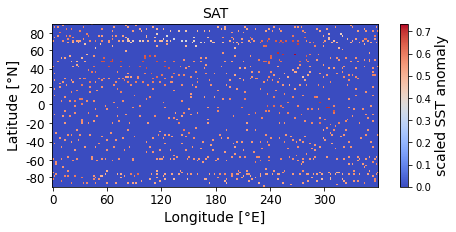

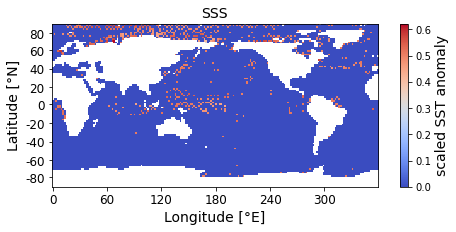

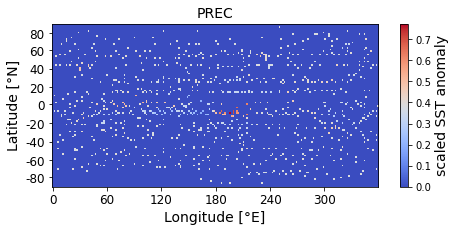

In [104]:
# Select input sample, according to specified target.
# The plots are only used for illustration, hence, ignore time shift.
single_test_input = test_input[sample]

# Highlight land masses for sst and sss channels, by setting undefined values to NaN:
single_test_input[:,:,1][test_target[sample]==0] = float('nan')
single_test_input[:,:,4][test_target[sample]==0] = float('nan')

## Plot sparse inputs for all channels:

# Loop over channels:
for c in range(single_test_input.shape[-1]):
    
    # Plot input for current channel:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(single_test_input[:,:,c], cmap="coolwarm", interpolation='nearest')#, vmin=0.35, vmax=0.65)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title(input_features_short_capital[c], fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

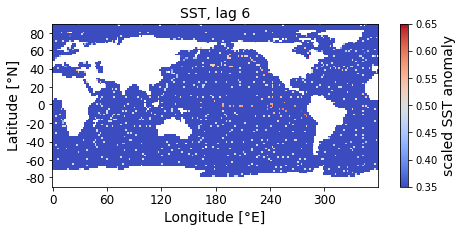

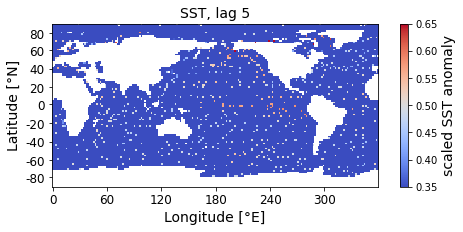

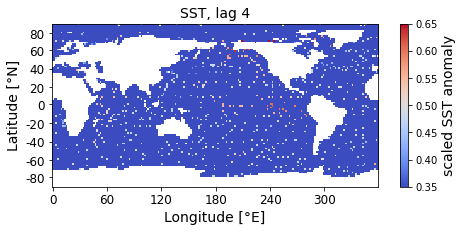

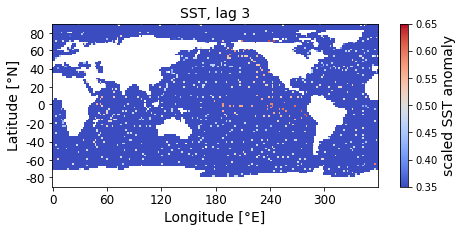

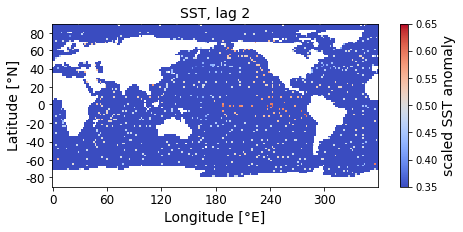

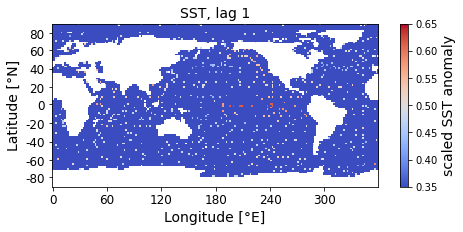

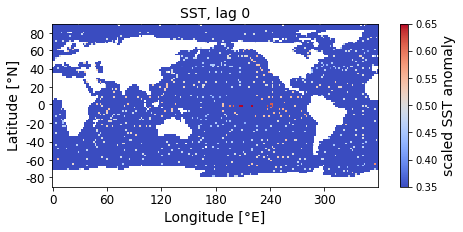

In [115]:
# Select input samples for selected channel (sst) with time lag.
single_test_input_timelagged = test_input[sample-6:sample+1,:,:,1]

# Highlight land masses for sst and sss channels, by setting undefined values to NaN:
single_test_input_timelagged[test_target[sample-6:sample+1]==0] = float('nan')

## Plot sparse inputs for time lags:

# Loop over time:
for l in range(7):
    
    # Plot input for current channel:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(single_test_input_timelagged[l,:,:], cmap="coolwarm", interpolation='nearest', vmin=0.35, vmax=0.65)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SST anomaly", fontsize=14)
    plt.title(input_features_short_capital[1]+', lag '+str(6-l), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

In [108]:
single_test_input_timelagged.shape

(7, 96, 192)